In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
#locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [4]:
datos = []
for dirname, dirnames, filenames in os.walk('./BD/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['./BD/SAMU 01-07-2020 al 31-07-2020.xlsx',
 './BD/SAMU 01-01-2020 al 31-03-2020.xlsx',
 './BD/SAMU 01-05-2020 al 31-05-2020.xlsx',
 './BD/SAMU 01-06-2020 al 31-06-2020.xlsx',
 './BD/SAMU 01-01-2018 al 31-12-2018.xlsx',
 './BD/SAMU 01-01-2019 al 31-12-2019.xlsx',
 './BD/SAMU 01-04-2020 al 30-04-2020.xlsx',
 './BD/SAMU 01-08-2020 al 31-08-2020.xlsx',
 './BD/eSAMU.pkl']

selecciono algunos...

In [5]:
archivos_eSAMU = [f for f in datos if '.xls' in f]

dejo todo lo que tengo como un solo objeto: BD

In [6]:
BD = pd.DataFrame()
for f in archivos_eSAMU:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139903 entries, 0 to 4822
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Id                        139903 non-null  int64  
 1   Fecha                     139903 non-null  object 
 2   Motivo del Llamado        139895 non-null  object 
 3   Submotivo del Llamado     139895 non-null  object 
 4   Prioridad                 100079 non-null  object 
 5   Estado                    139903 non-null  object 
 6   Edad                      133732 non-null  float64
 7   Género                    133301 non-null  object 
 8   Dirección                 119094 non-null  object 
 9   Sector                    93546 non-null   object 
 10  Comuna                    123440 non-null  object 
 11  Región                    136733 non-null  object 
 12  Intervención              139903 non-null  object 
 13  Tipo Traslado             139903 non-null  obj

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [7]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [8]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S')

In [9]:
BD['Fecha'].describe()

count                  139903
unique                 123690
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-08-31 23:58:54
Name: Fecha, dtype: object

Luego defino aquellas variables que debo hacer algo similar

In [10]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado',
    'En Regulación', 'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado'
]

ahora lo hago

In [11]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(
        BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [12]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [13]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2020-07-31 23:55:20,NaT,2020-08-01 00:03:42,2020-08-01 00:03:45,NaT,NaT,2020-08-01 03:38:18,NaT,NaT,NaT,NaT,2020-08-01 03:42:23,AP 14,173592
1,2020-07-31 23:55:02,NaT,2020-07-31 23:58:47,2020-08-01 00:03:47,2020-08-01 00:15:23,2020-08-01 00:29:13,2020-08-01 00:36:19,NaT,2020-08-01 01:25:01,2020-08-01 01:24:25,2020-08-01 01:29:17,2020-08-01 08:58:37,R22,173591


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,00:08:22,00:00:03,NaT,NaT,NaT,NaT
1,00:03:45,00:05:00,00:11:36,01:26:14,-1 days +23:59:24,00:04:16


count                  139903
unique                 123690
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-08-31 23:58:54
Name: Fecha, dtype: object

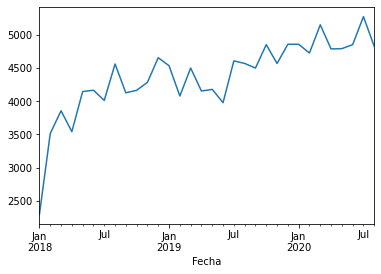

In [14]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [15]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,139901,100.0
True,2,0.0
Total,139903,100.0


,n,%
Diff_Despacho_Salida,,
False,139898,100.0
True,5,0.0
Total,139903,100.0


,n,%
Diff_salida_enellugar,,
False,139830,99.95
True,73,0.05
Total,139903,100.00


,n,%
Diff_z6_1,,
False,139900,100.0
True,3,0.0
Total,139903,100.0


,n,%
Diff_z6_2,,
False,139128,99.45
True,775,0.55
Total,139903,100.00


,n,%
Diff_z6_3,,
False,138381,98.91
True,1522,1.09
Total,139903,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [16]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [17]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,139903,100.0
Total,139903,100.0


count                     69307
mean     0 days 00:59:48.437719
std      0 days 03:26:24.797131
min             0 days 00:00:07
25%             0 days 00:06:37
50%             0 days 00:15:06
75%             0 days 00:54:34
max            13 days 15:06:32
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,139903,100.0
Total,139903,100.0


count                     55730
mean     0 days 00:07:53.211788
std      0 days 00:17:44.163651
min             0 days 00:00:02
25%             0 days 00:00:53
50%             0 days 00:03:16
75%      0 days 00:08:07.750000
max             1 days 02:44:39
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,139903,100.0
Total,139903,100.0


count                     44385
mean     0 days 00:15:18.868739
std      0 days 00:20:22.633707
min             0 days 00:00:01
25%             0 days 00:05:08
50%             0 days 00:10:19
75%             0 days 00:18:01
max             0 days 15:34:05
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,139903,100.0
Total,139903,100.0


count                      6470
mean     0 days 01:42:23.313601
std      0 days 01:04:24.853077
min             0 days 00:00:03
25%      0 days 01:02:47.250000
50%      0 days 01:27:24.500000
75%      0 days 02:02:15.500000
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,139903,100.0
Total,139903,100.0


count                      1012
mean     0 days 01:44:03.082015
std      0 days 02:15:59.616887
min             0 days 00:00:02
25%      0 days 00:10:35.750000
50%      0 days 00:57:20.500000
75%      0 days 02:21:07.250000
max             0 days 15:18:50
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,139903,100.0
Total,139903,100.0


count                      2479
mean     0 days 02:06:06.972972
std      0 days 02:22:52.480028
min             0 days 00:00:02
25%      0 days 00:31:42.500000
50%             0 days 01:19:53
75%      0 days 02:50:32.500000
max             1 days 04:20:28
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [18]:
BD.to_pickle('./BD/eSAMU.pkl')

# Datos generales

In [19]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

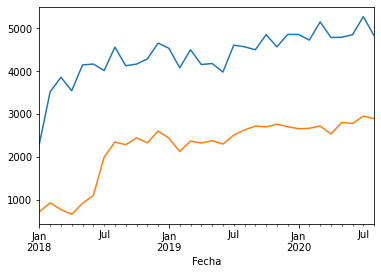

In [20]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

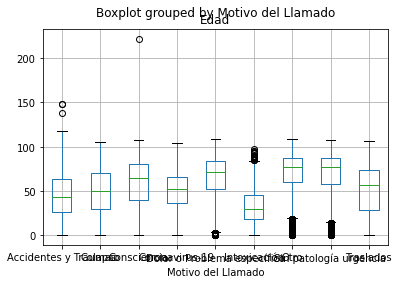

In [21]:
BD.boxplot('Edad', by = 'Motivo del Llamado')

cantidad de REM ingresados a eSAMU

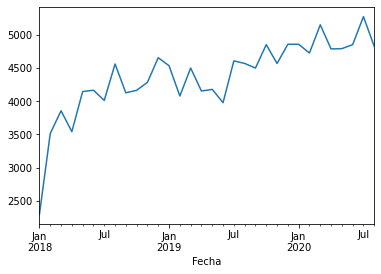

In [22]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

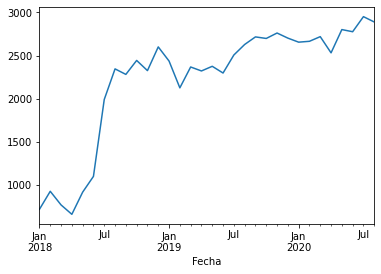

In [23]:
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()
# BD